In [2]:
import os
import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Tracab as tracab
# import Tracking_Visuals as vis
# import Tracking_Velocities as vel
# import Tracking_Fatigue as fatigue
# import helpers
# import importlib
# # importlib.reload(tracab)
# # importlib.reload(helpers)
# # importlib.reload(vis)

from scipy.optimize import curve_fit
from collections import defaultdict

In [135]:
sns.set()
# get paths
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data_processed')
all_data_processed = [os.path.join(data_path, f) for f in os.listdir(data_path)]
game_dicts = {f.split('/')[-1].split('.')[0].split('_')[-1]: f for f in all_data_processed 
              if f.find('.pkl') != -1}

In [549]:
data = pd.read_csv('./dataset_final.csv')

In [550]:
data['b2*10000'] = data['b2'] * 10000

# Plots

No handles with labels found to put in legend.


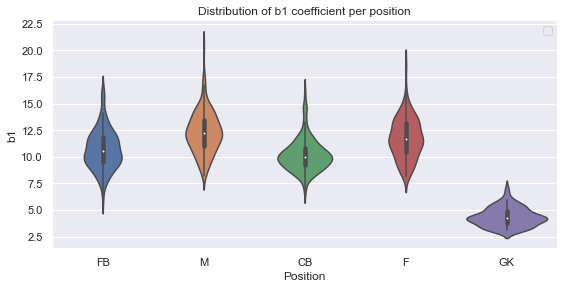

In [515]:
sns.catplot(x='start_pos_super', y='b1',
            data=data, height=4, aspect=2, kind='violin')

plt.title('Distribution of b1 coefficient per position')
plt.xlabel('Position')
plt.legend()


plt.show()

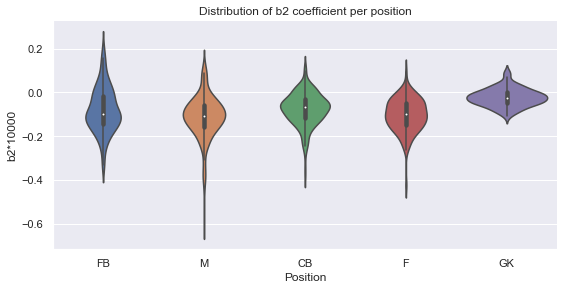

In [43]:
sns.catplot(x='start_pos_super', y='b2*10000',
            data=data, height=4, aspect=2, kind='violin')

plt.title('Distribution of b2 coefficient per position')
plt.xlabel('Position')
plt.show()

In [548]:
# fig, ax = plt.subplots(figsize=(12, 12), dpi=80)
g = sns.FacetGrid(data, col="start_pos_super",  col_wrap=3, palette='Blues_d',
                  height=4, aspect=1)
g = g.map(plt.scatter, "b1", "b2*10000", marker='+')

In [554]:
data['b2_scaled'] = data['b2'].divide(data['sigma_b2'])
data['b1_scaled'] = data['b1'].divide(data['sigma_b1'])

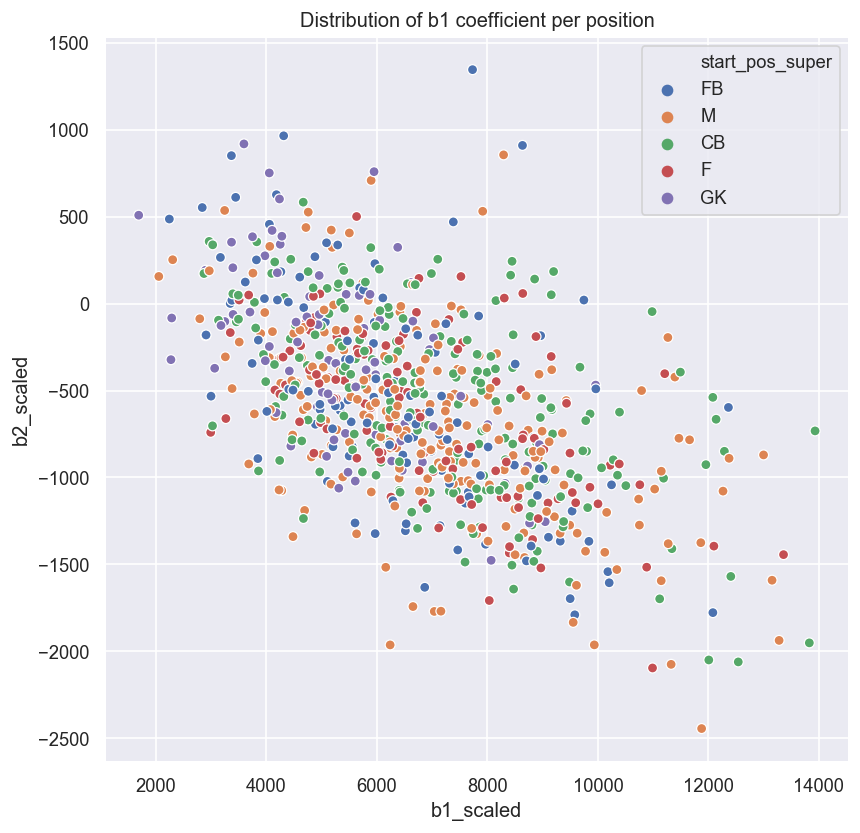

In [555]:
# b1 vs b2
fig, ax = plt.subplots(figsize=(8, 8), dpi=120)

sns.scatterplot(x='b1_scaled', y='b2_scaled', hue='start_pos_super',
                data=data, ax=ax)

plt.title('Distribution of b1 coefficient per position')

plt.show()

In [97]:
def poly_2nd(x, b, c):
    return 0 + (b * x) + (c * x ** 2)

def plays_full_game(EX_series, thresh=0.95):
    is_full = np.count_nonzero(EX_series)/len(EX_series) > thresh 
    return is_full

In [124]:
match_id = 984477
path = '/Users/jeffbalkanski/research_soccer/data_processed/EX_time_series_game_{}.pkl'.format(match_id)
with open(path, 'rb') as infile:
    data_dict = pickle.load(infile)

In [431]:
# fit model for each game
coefs = {}
for _, player_id, series in data_dict['energy_x']:
    EX_cumul = np.cumsum(series)
    frame_lst = np.array(range(len(EX_cumul)))

    # check if is subbed out
    if not plays_full_game(series):
        continue

    # fit second degree polynomial that passes through origin
    popt, pcov = curve_fit(poly_2nd, frame_lst, EX_cumul)

    # store info
    coefs[player_id] = [*popt, *np.sqrt(np.diag(pcov))]
    

135354
B1 = 13.214
B2 = -1.982e-05


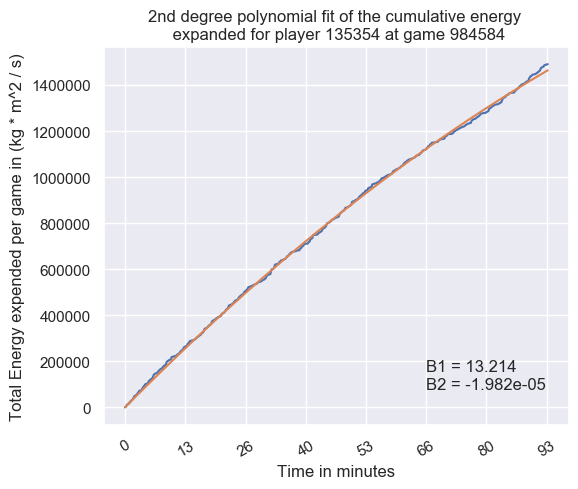

In [513]:
for _, player_id, series in data_dict['energy_x']:
    if player_id not in coefs or player_id != 135354:
        continue
    print(player_id)
    b1, b2, _, _ = coefs[player_id]
    
    print('B1 = {}'.format(round(b1, 3)))
    print('B2 = {}'.format(np.round(b2, 8)))
    
    frame_lst = np.array(range(len(series)))
    poly_fit_2 = b2*np.power(frame_lst, 2) + b1*frame_lst
    
    fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
    n = len(np.cumsum(series))
    mins = np.round(np.array(list(range(n))) * 0.04 /60)
    ax.plot(np.cumsum(series))
    ax.plot( poly_fit_2)
    plt.title('2nd degree polynomial fit of the cumulative energy \n expanded for player {} at game {}'.format(player_id, match_id))
    plt.xticks(rotation=30)
    ticks = map(int, (ax.get_xticks() * 0.04 /60))
    ax.set_xticklabels(ticks)
    plt.xlabel('Time in minutes')
    plt.ylabel('Total Energy expended per game in (kg * m^2 / s)')
    plt.text(100000, 80000, 'B1 = {}'.format(round(b1, 3)) + '\n' + 'B2 = {}'.format(np.round(b2, 8)))
    plt.show()


In [477]:
    mins = np.round(np.array(list(range(n))) * 0.04 /60)
mins

array([ 0.,  0.,  0., ..., 94., 94., 94.])

# Energy expended in possession

In [315]:
EX_in_possession = {'GK': {0:0, 1:0}, 
           'CB':{0:0, 1:0}, 
           'FB':{0:0, 1:0}, 
           'M':{0:0, 1:0}, 
           'F':{0:0, 1:0}}
pos_counts = {'GK': 0,  'CB':0,  'FB':0, 'M':0, 'F':0}

EX_in_possession

{'GK': {0: 0, 1: 0},
 'CB': {0: 0, 1: 0},
 'FB': {0: 0, 1: 0},
 'M': {0: 0, 1: 0},
 'F': {0: 0, 1: 0}}

In [316]:
# for each game
for match_id, path in game_dicts.items():    
    with open(path, 'rb') as infile:
        data_dict = pickle.load(infile)
    
    # fit model for each game
    for _, player_id, series in data_dict['energy_x']:
        # check if is subbed out
        if not plays_full_game(series):
            continue
        player_info = data_dict['player_info'].set_index('player_id').loc[player_id]
        team = player_info['Team']
        position = player_info['start_pos_super']
        possession = np.array(list((map(lambda x: 0. if x == 'A' else 1., data_dict['ball_in_play'][:, 1]))))
        in_possession = possession == team
        
        # count positions
        pos_counts[position] += 1
        
        df = pd.DataFrame(np.array([in_possession[:-2], series]).T,
                         columns=['in_possession', 'EX'])
        
        for_one = df.groupby('in_possession').sum()
        
        for k, v in for_one.to_dict()['EX'].items():
            EX_in_possession[position][k] += v
    
    print('Done with match {}'.format(match_id))

Done with match 984600
Done with match 984601
Done with match 984577
Done with match 984603
Done with match 984617
Done with match 984602
Done with match 984613
Done with match 984565
Done with match 984571
Done with match 984567
Done with match 984605
Done with match 984610
Done with match 984572
Done with match 984566
Done with match 984515
Done with match 984529
Done with match 984514
Done with match 984477
Done with match 984517
Done with match 984473
Done with match 984472
Done with match 984504
Done with match 984510
Done with match 984459
Done with match 984534
Done with match 984497
Done with match 984468
Done with match 984496
Done with match 984535
Done with match 984521
Done with match 984494
Done with match 984457
Done with match 984495
Done with match 984481
Done with match 984532
Done with match 984491
Done with match 984484
Done with match 984527
Done with match 984533
Done with match 984519
Done with match 984492
Done with match 984487
Done with match 984518
Done with m

In [317]:
EX_in_possession

{'GK': {0: 34567305.95000009, 1: 35352309.430000275},
 'CB': {0: 216945113.48000297, 1: 165819745.09000215},
 'FB': {0: 112657046.49000187, 1: 100322586.63000162},
 'M': {0: 263644018.11000362, 1: 234161367.04000333},
 'F': {0: 89305000.5200013, 1: 104299859.74000156}}

In [319]:
for pos, d in EX_in_possession.items():
    print(pos, EX_in_possession[pos])
    n = pos_counts[pos]
    EX_in_possession[pos][0] /= n
    EX_in_possession[pos][1] /= n

GK {0: 34567305.95000009, 1: 35352309.430000275}
CB {0: 216945113.48000297, 1: 165819745.09000215}
FB {0: 112657046.49000187, 1: 100322586.63000162}
M {0: 263644018.11000362, 1: 234161367.04000333}
F {0: 89305000.5200013, 1: 104299859.74000156}


In [320]:
toplot_EX_in_possession = pd.DataFrame(EX_in_possession).stack().reset_index()\
                                .rename({'level_0':'in_possession', 'level_1':'position', 0:'total_energy'}, axis=1)

In [345]:
toplot_EX_in_possession

,in_possession,position,total_energy
0,0,GK,285680.214463
1,0,CB,740427.008464
2,0,FB,726819.654774
3,0,M,813716.105278
4,0,F,676553.034242
5,1,GK,292167.846529
6,1,CB,565937.696553
7,1,FB,647242.494387
8,1,M,722720.268642
9,1,F,790150.452576


In [410]:
dE = []
for pos in toplot_EX_in_possession['position'].unique() :
    tmp = toplot_EX_in_possession[toplot_EX_in_possession['position'] == pos]
    E_not_in_pos = tmp[tmp['in_possession'] == 0]['total_energy'].values[0]
    E_in_pos = tmp[tmp['in_possession'] == 1]['total_energy'].values[0]

    dE.append((pos, round(((E_in_pos - E_not_in_pos) / (E_in_pos+ E_not_in_pos) * 100), 2)))

In [411]:
dE=[((x[0], str(x[1]) + ' %') if x[1] < 0 else (x[0],'+' +str(x[1]) + ' %')) for x in dE]

In [412]:
dE

[('GK', '+1.12 %'),
 ('CB', '-13.36 %'),
 ('FB', '-5.79 %'),
 ('M', '-5.92 %'),
 ('F', '+7.75 %')]

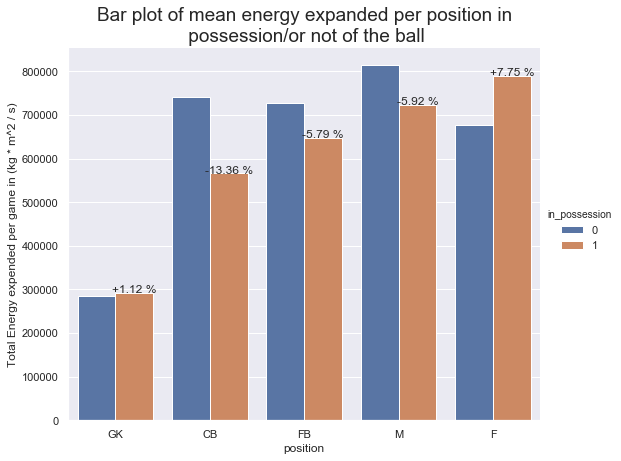

In [421]:
# fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

ax = sns.catplot(
    data=toplot_EX_in_possession,
    x='position', y='total_energy', hue='in_possession',
    kind='bar', height=6, aspect=1.3
)

for d, p in zip(dE, ax.axes[0][0].patches[5:]):
    height = p.get_height()
    ax.axes[0][0].text(
        p.get_x()+p.get_width()/2.,
            height + 3,
#             '{:1.2f}'.format(height/total),
            d[1],
            ha="center") 

plt.ylabel('Total Energy expended per game in (kg * m^2 / s)')
plt.title('Bar plot of mean energy expanded per position in\n possession/or not of the ball',
         fontsize=19)
plt.show()


In [ ]:
{'GK': {0: 34567305.95000009, 1: 35352309.430000275},
 'CB': {0: 216945113.48000297, 1: 165819745.09000215},
 'FB': {0: 112657046.49000187, 1: 100322586.63000162},
 'M': {0: 263644018.11000362, 1: 234161367.04000333},
 'F': {0: 89305000.5200013, 1: 104299859.74000156}}

,in_possession,position,total_energy
0,0,GK,285680.214463
1,0,CB,740427.008464
2,0,FB,726819.654774
3,0,M,813716.105278
4,0,F,676553.034242
5,1,GK,292167.846529
6,1,CB,565937.696553
7,1,FB,647242.494387
8,1,M,722720.268642
9,1,F,790150.452576


,position,in_possession,total_energy
0,CB,1,1.306365e+06
1,F,1,1.466703e+06
2,FB,1,1.374062e+06
3,GK,1,5.778481e+05
4,M,1,1.536436e+06


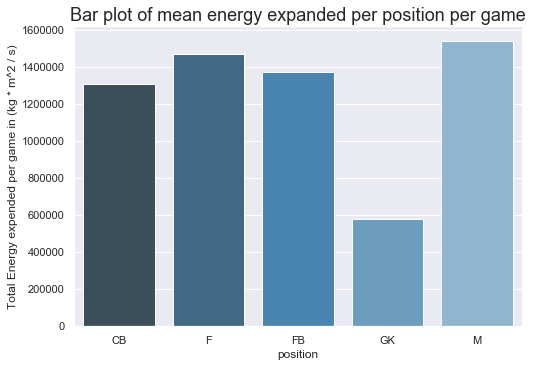

In [343]:


sns.catplot(
    data=toplot_EX_in_possession.groupby('position').sum().reset_index(),
    x='position', y='total_energy',
    kind='bar',  palette="Blues_d",
    height=5, aspect=1.5
)
plt.ylabel('Total Energy expended per game in (kg * m^2 / s)')

plt.title('Bar plot of mean energy expanded per position per game'.format(match_id), fontsize=18)
plt.show()

# Distribution of errors of the 2nd degree fit

In [516]:
model_and_player_data = pd.read_csv('./dataset_final.csv')

In [544]:
model_and_player_data['sigma_b2*e^'] = model_and_player_data['sigma_b2'] * 1000000
model_and_player_data['sigma_b1*e^'] = model_and_player_data['sigma_b1'] * 10000

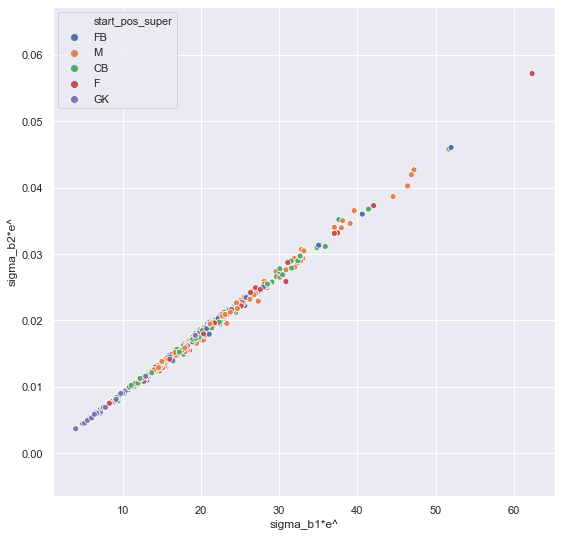

In [545]:
fig, ax=plt.subplots(figsize=(9, 9))
sns.scatterplot(data=model_and_player_data,
            x='sigma_b1*e^', y='sigma_b2*e^', hue='start_pos_super',
           ax=ax
           )
plt.show()